In [1]:
# %pip install kagglehub --quiet
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import sklearn

# Frame The Problem And Look At The Big Picture

1. **Define the objective in business terms**:

   <mark>TODO</mark>

2. **How will your solution be used**:

   <mark>TODO</mark>

3. **Current solutions/workarounds**:

   - **Manual animal species tagging**: Biologists will look at a animal and inspect it to make sure that it is sent to the right enclosure.
   <!-- - **Existing services**: Some platforms offer genre classification, such as Submithub, but they lack the scale and integration needed for large music libraries. -->

4. **Problem framing**:

   - **Supervised learning**: We have labeled data (pictures with labels).
   - **Multi-class classification**: The task is to classify pictures of animals into the 10 respective classes.
   - **Use case**: The system will be used in the Bronx zoo to classify animals to make sure they go to the right enclosure.

5. **Performance measurement**:

   - **Precision (macro)**: We are using precision (macro) because we are highly concerned that if we miss classify a animal like a bobcat and a coyote and they end up in the same enclosure could mean very big issues for the zoo and animals.
   - **Success criteria**: A precision of 80% would be acceptable in this problem because the workers would get a general idea and a expert could give the animal classification a once over to ensure, which would keep the process efficient.

6. **Comparable problems**:

   - **Computer Vision**: most if not all of the comparable problems to our business problem are all some sort of computer vision classification. Like intel image classification, and even things like urban sound 8k because they train on spectograms.

7. **Human expertise availability**:

   - **Biology experts**: While biology experts can accuracy classify animals to make sure they are being directed to the right enclosure but this takes a large amount of time, our aim is to shorten this process by providing a service to classify the animals to the correct enclosures only requiring a once over from the expert.
   - **Availability**: There is available expertise in the bronx zoo, this expertise include people that can accurately classify animals to the correct enclosures.

8. **Manual solution process**:

   A human would:
      Ask experts in the field to classify these animals, this way the animals would be correctly classified into the correct enclosures.




### Downloading the data

This script downloads the Animals10 dataset and organizes it into a flat directory structure. It renames the Italian class folder names to English using a translation dictionary. Finally, it creates a Pandas DataFrame with image file paths and their corresponding labels for training.

In [17]:
def download_data():
    path = kagglehub.dataset_download("alessiocorrado99/animals10")

    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
    }

    os.makedirs("./data", exist_ok=True)
    shutil.move(path, "./data")
    for directory in os.listdir("./data/2/raw-img"):
        full_path = os.path.join("./data/2/raw-img", directory)
        if os.path.isdir(full_path):
            shutil.move(full_path, "./data")
    shutil.rmtree("./data/2")

    for folder in os.listdir("./data"):
        full_path = os.path.join("./data", folder)
        if os.path.isdir(full_path):
            new_folder_name = translate.get(folder, folder)
            new_full_path = os.path.join("./data", new_folder_name)
            if new_full_path != full_path:
                os.rename(full_path, new_full_path)

    print("Dataset downloaded and organized in './data' directory.")

def load_meta_data():
    file_names = []
    labels = []

    for folder in os.listdir("./data"):
        for file in os.listdir(os.path.join("./data", folder)):
            full_path = os.path.join("./data", folder, file)
            if os.path.isfile(full_path):
                file_names.append(full_path)
                labels.append(folder)

    meta_data = pd.DataFrame({
        'file_path': file_names,
        'label': labels
    })
    meta_data['label'] = meta_data['label'].astype('category')
    return sklearn.model_selection.train_test_split(meta_data, test_size=0.2, random_state=42, stratify=meta_data['label'])

In [19]:
train_set, test_set = load_meta_data()
train_set.head(10)

,file_path,label
10492,./data\dog\OIP-Fy6X3QdDD2GICos_g-CkygHaHa.jpeg,dog
15065,./data\horse\OIP--Hoe5PVuFl7QUqfg5SYNWwHaFj.jpeg,horse
668,./data\butterfly\OIP-6cpoMjN1R_lgziI9Lnz1UwHaE...,butterfly
6428,./data\chicken\OIP-USImzKVLQ3nw2xhhmri-2wHaFj....,chicken
17400,./data\horse\OIP-x1dmwXyO7sHratpL_SI8VQHaFC.jpeg,horse
23538,./data\spider\OIP-UzxfkKkYu_VJW_YXXJrlDwHaH2.jpeg,spider
6453,./data\chicken\OIP-v02hj9zYnxBIs1lfH-7UbgHaFj....,chicken
7550,./data\cow\OIP-fclqGfYrRH1j7ESfpmATMQHaGw.jpeg,cow
13634,./data\elephant\e834b20f28fd003ed1584d05fb1d4e...,elephant
13622,./data\elephant\e831b4082cf1013ed1584d05fb1d4e...,elephant


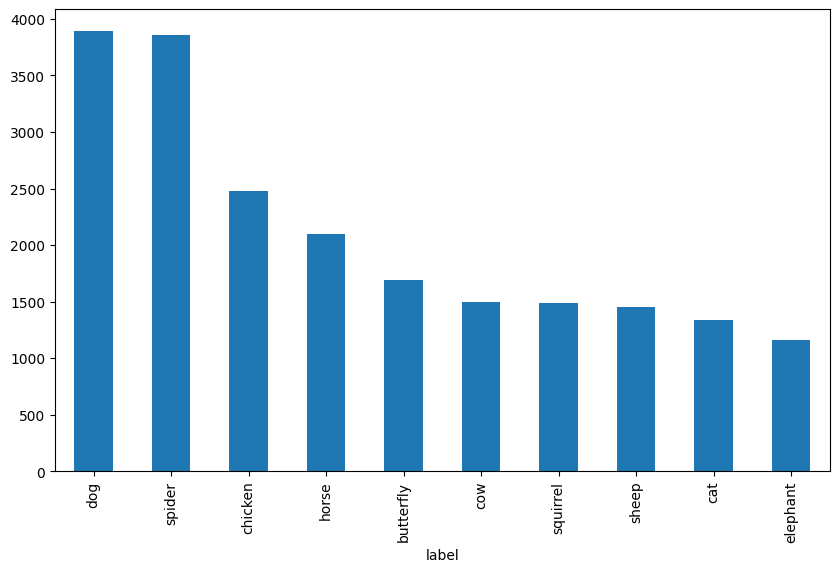

In [20]:
train_set["label"].value_counts().plot(kind='bar', figsize=(10, 6));

In [29]:
def create_data_generators(train_set, test_set, img_size=(300, 300), batch_size=32):
    def pad_and_rescale(image):
        image = tf.image.resize_with_pad(image, target_height=img_size[0], target_width=img_size[1])
        image = image / 255.0
        return image
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    return train_generator, test_generator

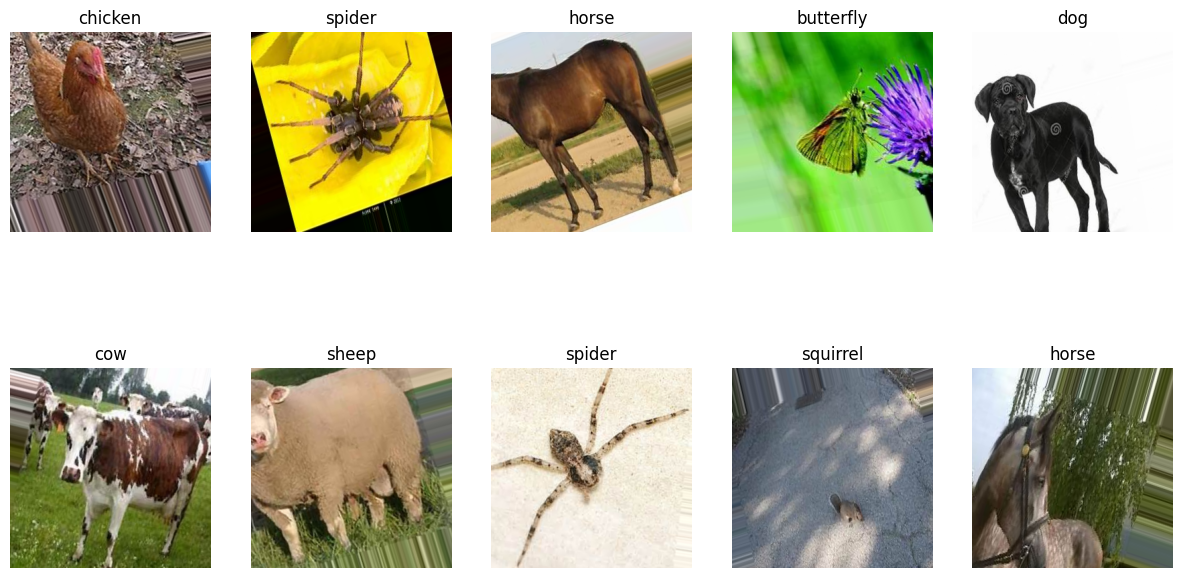

In [ ]:
plt.figure(figsize=(15, 8))
for i, (img, label) in enumerate(zip(train_generator[0][0], train_generator[0][1])):
    if i >= 10:
        break
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    plt.title(class_names[label.argmax()])
    plt.axis('off')

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\Colea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 300, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │    21,233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,658,442 (82.62 MB)

 Trainable params: 21,657,482 (82.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [37]:
train_generator, test_generator = create_data_generators(train_set, test_set, img_size=(300, 300), batch_size=32)

Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [38]:
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
    ]
)

c:\Users\Colea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.2571 - loss: 3.5666 - val_accuracy: 0.4314 - val_loss: 1.6851
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1343s 2s/step - accuracy: 0.4245 - loss: 1.6846 - val_accuracy: 0.4062 - val_loss: 1.8033
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.4986 - loss: 1.4621 - val_accuracy: 0.4786 - val_loss: 1.6726
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.5506 - loss: 1.3038 - val_accuracy: 0.5995 - val_loss: 1.2038
Epoch 5/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.6023 - loss: 1.1635 - val_accuracy: 0.5634 - val_loss: 1.3408
Epoch 6/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1618s 2s/step - accuracy: 0.6414 - loss: 1.0486 - val_accuracy: 0.5063 - val_loss: 1.7200
Epoch 7/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1767s 3s/step - accuracy: 0.6696 - loss: 0.9753 - val_accuracy: 0.6713 - val_loss: 1.0278
Epoch 8/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1752s 3s/step - accuracy: 0.6867 - loss: 0.9203 - 

Epoch 1/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.2571 - loss: 3.5666 - val_accuracy: 0.4314 - val_loss: 1.6851
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1343s 2s/step - accuracy: 0.4245 - loss: 1.6846 - val_accuracy: 0.4062 - val_loss: 1.8033
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.4986 - loss: 1.4621 - val_accuracy: 0.4786 - val_loss: 1.6726
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.5506 - loss: 1.3038 - val_accuracy: 0.5995 - val_loss: 1.2038
Epoch 5/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.6023 - loss: 1.1635 - val_accuracy: 0.5634 - val_loss: 1.3408
Epoch 6/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1618s 2s/step - accuracy: 0.6414 - loss: 1.0486 - val_accuracy: 0.5063 - val_loss: 1.7200
Epoch 7/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1767s 3s/step - accuracy: 0.6696 - loss: 0.9753 - val_accuracy: 0.6713 - val_loss: 1.0278
Epoch 8/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1752s 3s/step - accuracy: 0.6867 - loss: 0.9203 - val_accuracy: 0.6616 - val_loss: 1.0653
Epoch 9/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1777s 3s/step - accuracy: 0.7093 - loss: 0.8637 - val_accuracy: 0.5959 - val_loss: 1.3065
Epoch 10/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 1769s 3s/step - accuracy: 0.7204 - loss: 0.8308 - val_accuracy: 0.6841 - val_loss: 1.0580

In [ ]:
predictions = model.predict(test_generator, verbose=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 45s 272ms/step


In [52]:
for i in range(10):
    for x in predictions[i]:
        print(f"Prediction {i+1}: {x * 100:.2f}%")
    print("\n" + "="*50 + "\n")

Prediction 1: 7.61%
Prediction 1: 0.33%
Prediction 1: 4.28%
Prediction 1: 0.01%
Prediction 1: 0.03%
Prediction 1: 0.06%
Prediction 1: 0.05%
Prediction 1: 0.07%
Prediction 1: 87.54%
Prediction 1: 0.02%


Prediction 2: 3.21%
Prediction 2: 3.25%
Prediction 2: 7.78%
Prediction 2: 1.95%
Prediction 2: 15.56%
Prediction 2: 1.54%
Prediction 2: 7.06%
Prediction 2: 0.57%
Prediction 2: 57.37%
Prediction 2: 1.71%


Prediction 3: 68.57%
Prediction 3: 0.03%
Prediction 3: 0.31%
Prediction 3: 0.00%
Prediction 3: 0.09%
Prediction 3: 0.00%
Prediction 3: 0.26%
Prediction 3: 0.00%
Prediction 3: 30.73%
Prediction 3: 0.00%


Prediction 4: 1.76%
Prediction 4: 17.19%
Prediction 4: 5.46%
Prediction 4: 0.24%
Prediction 4: 5.13%
Prediction 4: 1.56%
Prediction 4: 0.68%
Prediction 4: 2.33%
Prediction 4: 54.63%
Prediction 4: 11.03%


Prediction 5: 15.43%
Prediction 5: 0.36%
Prediction 5: 0.88%
Prediction 5: 0.02%
Prediction 5: 0.15%
Prediction 5: 0.07%
Prediction 5: 0.12%
Prediction 5: 0.01%
Prediction 5: 82.01%
Pr

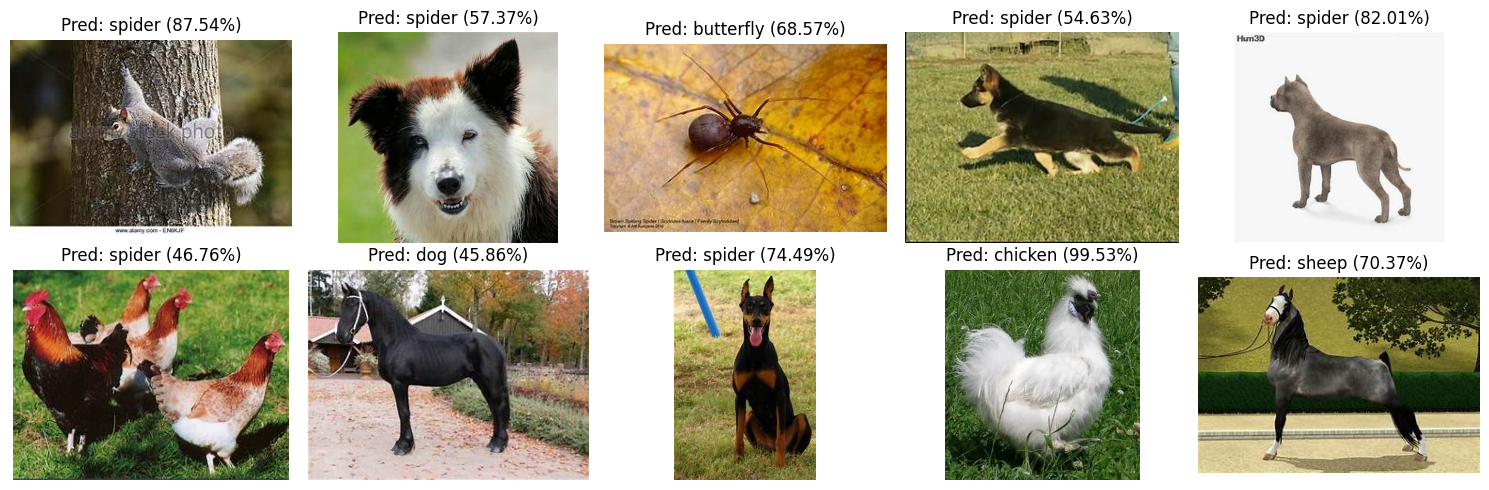

In [52]:
import matplotlib.image as mpimg
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[np.argmax(predictions[i])]} ({predictions[i][np.argmax(predictions[i])]*100:.2f}%)")
plt.tight_layout()

- Hilariously bad its basically just guessing that it is always going to be a spider, but on the actual spider it thinks it is going to be a butterfly.
- The percentage values is the confidence value so top right dog with a prediction of spider 82.01% means that the model is 82.01% certain that it is a spider.
- definitely some modifications we need to make to the model.